# Audio Data Preparation and Augmentation

## Overview

This notebook will be a good start on preparing and analyzing audio data. 

## Setup 

Install required packages, and restart runtime

In [1]:
!pip install tensorflow-io

## Usage

### Read an Audio File

In TensorFlow IO, class [tfio.audio.AudioIOTensor](https://www.tensorflow.org/io/api_docs/python/tfio/audio/AudioIOTensor) allows you to read an audio file into a lazy-loaded IOTensor:

In [2]:
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
import pandas as pd

audio = tfio.audio.AudioIOTensor('gs://cloud-samples-tests/speech/brooklyn.flac')

print(audio)

2022-04-13 20:31:31.908290: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA
2022-04-13 20:31:32.156260: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-13 20:31:32.463406: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "INTERNAL: Couldn't parse JSON response from OAuth server.".


<AudioIOTensor: shape=[28979     1], dtype=<dtype: 'int16'>, rate=16000>


In [3]:
audio.shape

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([28979,     1])>

In [4]:
print(audio[:])
print(len(audio[:]))
print(audio[0])

tf.Tensor(
[[-184]
 [-181]
 [-156]
 ...
 [  56]
 [  81]
 [  83]], shape=(28979, 1), dtype=int16)
28979
tf.Tensor([-184], shape=(1,), dtype=int16)


# Takeaways

* audio is an AudioIOTensor with a shape of [28979, 1]

In the above example, the Flac file `brooklyn.flac` is from a publicly accessible audio clip in [google cloud](https://cloud.google.com/speech-to-text/docs/quickstart-gcloud).

The GCS address `gs://cloud-samples-tests/speech/brooklyn.flac` are used directly because GCS is a supported file system in TensorFlow. In addition to `Flac` format, `WAV`, `Ogg`, `MP3`, and `MP4A` are also supported by `AudioIOTensor` with automatic file format detection.

`AudioIOTensor` is lazy-loaded so only shape, dtype, and sample rate are shown initially. The shape of the `AudioIOTensor` is represented as `[samples, channels]`, which means the audio clip you loaded is mono channel with `28979` samples in `int16`.

The content of the audio clip will only be read as needed, either by converting `AudioIOTensor` to `Tensor` through `to_tensor()`, or though slicing. Slicing is especially useful when only a small portion of a large audio clip is needed:

# Takeaways

* GCS(Google Cloud Storage)
* AudioIOTensor is represented as [samples, channels]
* AudioIOTensor data must be converted to a Tensor using to_tensor() or can be processed using slicing. 
* Slicing is useful when small portions of large audio clips are needed.

[tf.squeeze](https://www.tensorflow.org/api_docs/python/tf/squeeze) removes dimensions of size 1 from the shape of a tensor.

In [5]:
audio_slice = audio[100:]

# remove the last dimension
audio_tensor = tf.squeeze(audio_slice, axis=[-1])

print(audio_tensor)

tf.Tensor([16 39 66 ... 56 81 83], shape=(28879,), dtype=int16)


### The audio can be played through:

In [6]:
from IPython.display import Audio

Audio(audio_tensor.numpy(), rate = audio.rate.numpy())

It is more convenient to convert tensors into float numbers and express the audio clip as a graph:

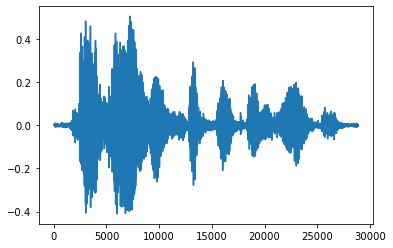

In [7]:
import matplotlib.pyplot as plt

tensor = tf.cast(audio_tensor, tf.float32) / 32768.0

plt.figure()
plt.plot(tensor.numpy())

### Trim the noise

Sometimes it makes sense to trim the noise from the audio, which could be done through API `tfio.audio.trim`. Returned from the API is a pair of `[start, stop]` position of the segment:

tf.Tensor([ 2398 23546], shape=(2,), dtype=int64)
tf.Tensor(2398, shape=(), dtype=int64) tf.Tensor(23546, shape=(), dtype=int64)


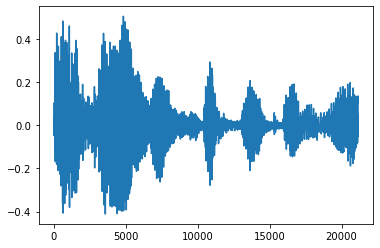

In [8]:
position = tfio.audio.trim(tensor, axis=0, epsilon=0.1)
print(position)

start = position[0]
stop = position[1]
print(start, stop)

processed = tensor[start:stop]

plt.figure()
plt.plot(processed.numpy())

### Fade In and Fade Out

One useful audio engineering technique is fade, which gradually increases or decreases audio signals. This can be done through [tfio.qudio.fade](https://www.tensorflow.org/io/api_docs/python/tfio/audio/fade). [tfio.qudio.fade](https://www.tensorflow.org/io/api_docs/python/tfio/audio/fade) supports different shapes of fades such as `linear`, `logarithmic`, or `exponential`:

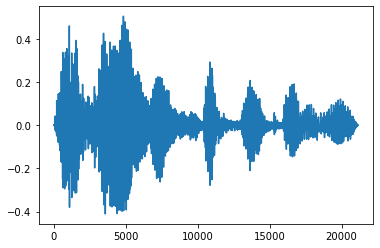

In [9]:
fade = tfio.audio.fade(
    processed, fade_in = 1000, fade_out = 2000, mode = 'logarithmic')

plt.figure()
plt.plot(fade.numpy())

### Spectrogram

Advanced audio processing often works on frequency changes over time. In `tensorflow-io` a waveform can be converted to spectrogram through `tfio.audio.spectrogram`:

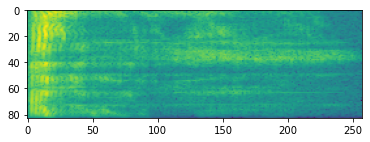

In [10]:
# Convert to spectrogram
spectrogram = tfio.audio.spectrogram(
    fade, nfft = 512, window = 512, stride = 256
)

plt.figure()
plt.imshow(tf.math.log(spectrogram).numpy())

Additional transformation to different scales are also possible:


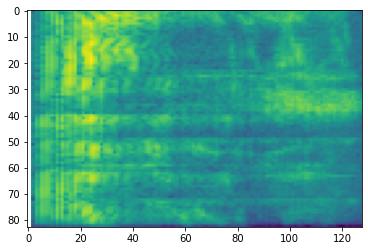

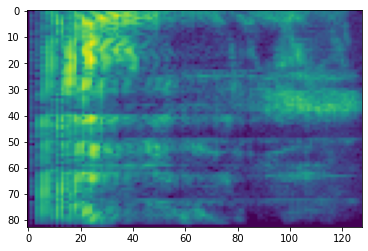

In [11]:
# Convert to mel-spectrogram
mel_spectrogram = tfio.audio.melscale(
    spectrogram, rate = 16000, mels = 128, fmin = 0, fmax = 8000)

plt.figure()
plt.imshow(tf.math.log(mel_spectrogram).numpy())

# Convert to db scale mel-spectrogram
dbscale_mel_spectrogram = tfio.audio.dbscale(
    mel_spectrogram, top_db = 80)

plt.figure()
plt.imshow(dbscale_mel_spectrogram.numpy())

### SpecAugment

In addition to the above mentioned data preparation and augmentation APIs, `tensorflow-io` package also provides advanced spectrogram augmentations, most notably Frequency and Time Masking discussed in [SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition (Park et al., 2019)](https://arxiv.org/pdf/1904.08779.pdf).

**Frequency Masking**

In frequency masking, frequency channels `[f0, f0 + f)` are masked where `f` is chosen from a uniform distribution from `0` to the frequency mask parameter `F`, and `f0` is chosen from `(0, v -f)` where `v` is the number of frequency channels.

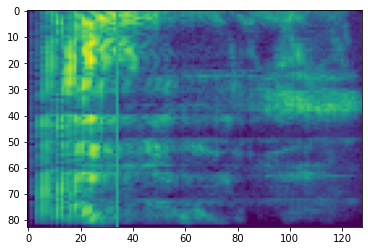

In [12]:
# Freq masking
freq_mask = tfio.audio.freq_mask(dbscale_mel_spectrogram, param = 10)

plt.figure()
plt.imshow(freq_mask.numpy())

**Time Masking**

In time masking, `t` consecutive time steps `[t0, t0 + t)` are masked where `t` is chosen from a uniform distribution from `0` to the time mask parameter `T`, and `t0` is chosen from `[0, tau - t)` where `tau` is the time steps.

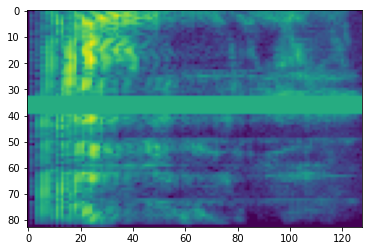

In [13]:
# Time masking
time_mask = tfio.audio.time_mask(dbscale_mel_spectrogram, param = 10)

plt.figure()
plt.imshow(time_mask.numpy())